In [5]:
from jaqpotpy.descriptors.molecular import MACCSKeysFingerprint, PubChemFingerprint, TopologicalFingerprint, MordredDescriptors
from jaqpotpy.models import MolecularSKLearn
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.models.evaluator import Evaluator

from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
import pandas as pd
import torch
import numpy as np

In [6]:
df = pd.read_csv('activity_MIC_thresh10_microg-per-ml.csv')
df.head()

,Sequence,SMILES,Activity
0,ENREVPPGFTALIKTLRKCKII,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN...,0
1,NLVSGLIEARKYLEQLHRKLKNCKV,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)CNC(=...,0
2,WLNALLHHGLNCAKGVLA,CC(C)C[C@H](NC(=O)CNC(=O)[C@H](Cc1c[nH]cn1)NC(...,0
3,KLALKAALKAWKAAAKLA,CC(C)C[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](...,0
4,KLALKAAAKAWKAAAKAA,CC(C)C[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](...,0


In [7]:
len(df)

6225

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
smiles = df['SMILES']
activity = df['Activity']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(smiles, activity, test_size=0.20, random_state=42)

In [11]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=42)

In [12]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [13]:
len(X_train), len(X_val), len(X_test)

(4980, 622, 623)

In [14]:
featurizer = MACCSKeysFingerprint()

In [15]:
jaq_train = SmilesDataset(smiles = X_train, y = y_train, featurizer = featurizer)
jaq_train.create()

Creating descriptors: 100%|███████████████████████████████████████████████████████| 4980/4980 [00:38<00:00, 130.03it/s]


SmilesDataset

In [37]:
jaq_val = SmilesDataset(smiles = X_val, y = y_val, featurizer = featurizer)
jaq_val.create()

Creating descriptors: 100%|█████████████████████████████████████████████████████████| 622/622 [00:05<00:00, 114.33it/s]


SmilesDataset

In [38]:
jaq_train.df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f158,f159,f160,f161,f162,f163,f164,f165,f166,Y
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0


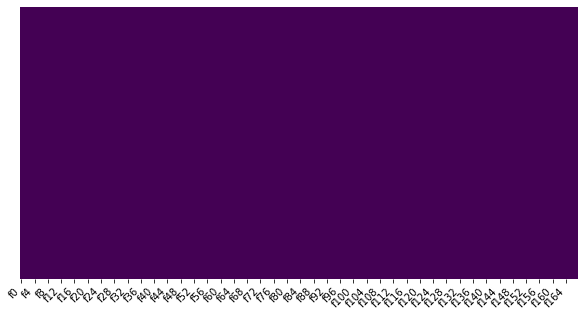

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.heatmap(jaq_train.df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.xticks(rotation=45,horizontalalignment='right');

In [40]:
val = Evaluator()
val.dataset = jaq_val
val.register_scoring_function('Accuracy', accuracy_score)
val.register_scoring_function('ROC', roc_auc_score)

In [41]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import (accuracy_score,matthews_corrcoef,
                             classification_report, confusion_matrix, f1_score, roc_auc_score )
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

In [72]:
# m = LogisticRegression(C=100, penalty='elasticnet', solver='saga', l1_ratio=0.2, random_state=42)

# m = SVC(C=50, kernel='poly',gamma=0.2, random_state=10)
m = RandomForestClassifier(n_estimators=150, min_samples_split=4, max_depth=25, random_state=42)

# m = ExtraTreesClassifier(n_estimators=50, min_samples_split=4, max_depth=6, random_state=42)

# m = KNeighborsClassifier(metric='rogerstanimoto', n_neighbors=3)


# m = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.05,
#                 max_depth = 4, n_estimators = 50, random_state=42)


# m = VotingClassifier(estimators=[('sv', sv), ('kn', kn)])#, weights=[0.7,0.3])

In [73]:
model = MolecularSKLearn(jaq_train, doa=None, model=m, eval=val)

In [74]:
m1 = model.fit()

c:\users\jason\centralenv\lib\site-packages\jaqpotpy\models\sklearn.py:77: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.trained_model = self.model.fit(X, y)


Accuracy: 0.8810289389067524
ROC: 0.6997385931558935


In [85]:
pred = m1(X_test.tolist())

Creating descriptors: 100%|█████████████████████████████████████████████████████████| 623/623 [00:04<00:00, 129.64it/s]


In [87]:
accuracy_score(y_test, m1.prediction)

0.8523274478330658

In [88]:
roc_auc_score(y_test, m1.prediction)


0.6475763049941666

In [89]:
m1.probability

[[0.9973333333333333, 0.002666666666666667],
 [0.8207436853928084, 0.17925631460719169],
 [0.9212539682539684, 0.07874603174603174],
 [0.7335244443092738, 0.266475555690726],
 [0.7756070479228366, 0.2243929520771625],
 [0.9482222222222222, 0.05177777777777778],
 [0.9933333333333333, 0.006666666666666667],
 [0.9991666666666666, 0.0008333333333333334],
 [0.9056031746031745, 0.09439682539682541],
 [0.5864324379324377, 0.41356756206756223],
 [0.8460079365079365, 0.15399206349206349],
 [0.852563492063492, 0.14743650793650792],
 [0.6632374118256469, 0.33676258817435284],
 [0.4864885740172137, 0.5135114259827863],
 [0.9558888888888888, 0.044111111111111115],
 [1.0, 0.0],
 [0.523975468975469, 0.4760245310245312],
 [0.3699074074074074, 0.6300925925925926],
 [0.7506675128102978, 0.2493324871897019],
 [0.9106666666666668, 0.08933333333333335],
 [0.7789259259259261, 0.22107407407407398],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [0.7303650793650794, 0.26963492063492067],
 [0.4901922777209174, 0.5098

In [90]:
m1.model_title='rf_maccs'
m1.save()